# Методы оптимизации

# Обучение с обычным SGD

Загрузим данные, создадим модель и обучим с обычным SGD.

USE CUDA: True
Train size: 10000
Test size: 10000


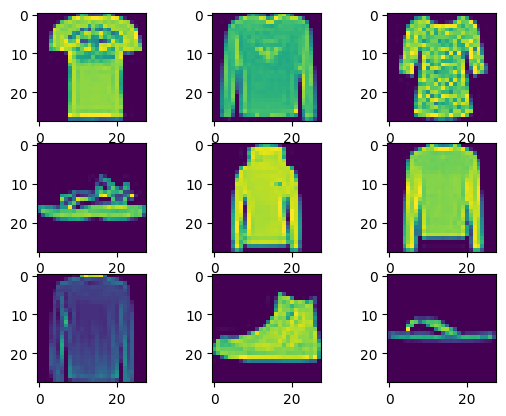

In [2]:
import torch
import numpy as np
import torchvision
from torchvision.datasets import FashionMNIST
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm, trange

USE_CUDA = torch.cuda.is_available()
print("USE CUDA:", USE_CUDA)

torch.manual_seed(0)
np.random.seed(0)

SUBSET_SIZE = 10000
BATCH_SIZE = 32

transform = torchvision.transforms.ToTensor()

train = FashionMNIST("mnist", train=True, transform=transform, download=True)
train = torch.utils.data.Subset(train, np.random.permutation(len(train))[:SUBSET_SIZE])
test = FashionMNIST("mnist", train=False, transform=transform, download=True)
print("Train size:", len(train))
print("Test size:", len(test))

def draw(dataset):
    images, labels = zip(*[dataset[i] for i in range(9)])
    fig, axs = plt.subplots(3, 3, squeeze=False)
    for i, image in enumerate(images):
        ax = axs[i // 3, i % 3]
        ax.imshow(image.permute(1, 2, 0).squeeze(-1))
    plt.show()

draw(train)

In [5]:
def compute_accuracy(model, loader):
    if USE_CUDA:
        model.cuda()
    model.eval()
    n_correct = 0
    n = 0
    for images, labels in tqdm(loader, leave=False):
        if USE_CUDA:
            images = images.cuda()
            labels = labels.cuda()
        n_correct += (model(images).argmax(dim=1) == labels).sum().item()
        n += len(images)
    return n_correct / n

Num parameters 3226


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0, loss 2.191, train 0.534, test 0.536


  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1, loss 1.213, train 0.690, test 0.687


  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2, loss 0.844, train 0.712, test 0.708


  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3, loss 0.777, train 0.723, test 0.715


  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4, loss 0.752, train 0.730, test 0.723
Weights norm 3.830393075942993


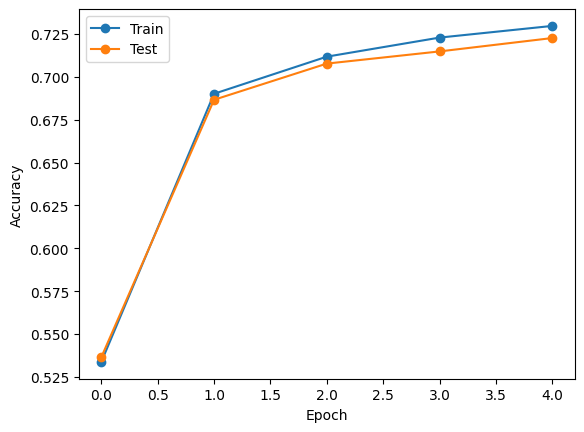

In [10]:
def get_model():
    torch.manual_seed(0)
    return torch.nn.Sequential(
        torch.nn.Conv2d(1, 4, 3, stride=2),
        torch.nn.ReLU(),
        torch.nn.Conv2d(4, 8, 3, stride=2),
        torch.nn.ReLU(),
        torch.nn.Flatten(),
        torch.nn.Linear(288, 10)
    )

def run(model, optimizer, epochs=10, scheduler=None):
    print("Num parameters", sum(map(torch.numel, model.parameters())))
    if USE_CUDA:
        model.cuda()
    criterion = torch.nn.CrossEntropyLoss()
    loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, drop_last=True)
    if scheduler is None:
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
    test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE)
    train_accuracies = []
    test_accuracies = []
    for epoch in trange(epochs):
        model.train()
        losses = []
        for images, labels in loader:
            if USE_CUDA:
                images = images.cuda()
                labels = labels.cuda()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())
        model.eval()
        with torch.no_grad():
          train_accuracy = compute_accuracy(model, loader)
          test_accuracy = compute_accuracy(model, test_loader)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        print(f"Epoch {epoch}, loss {np.mean(losses):.3f}, train {train_accuracy:.3f}, test {test_accuracy:.3f}")
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(np.mean(losses))
            else:
                scheduler.step()
    print("Weights norm", torch.linalg.norm(torch.concat([p.flatten() for p in model.parameters()])).item())
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(train_accuracies, label="Train", marker="o")
    plt.plot(test_accuracies, label="Test", marker="o")
    plt.legend()
    plt.show()

model = get_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        
run(model, optimizer, epochs=5)

При обучении с обычным SGD модель достигла точности 72.9% на тестовом корпусе. Попробуем улучшить.

# Улучшения

**Задание 1**. Примените `torch.optim.RMSprop`. Получите точность на test не меньше 82%.

In [ ]:
model = get_model()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)  # Ваш код.
        
run(model, optimizer)

**Задание 2.** Примените `torch.optim.Adam`. Получите точность на test не менее 83%.

In [ ]:
model = get_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Ваш код.

run(model, optimizer)

**Задание 3**. Примените momentum SGD. Получите точность на test не меньше 82%.

In [ ]:
model = get_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # Ваш код.
        
run(model, optimizer)

**Задание 4.** Примените Nesterov momentum. Получилось ли увеличить точность на train/test?

In [ ]:
model = get_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)  # Ваш код.
        
run(model, optimizer)

**Задание 5** Попробуйте добиться точности 83.5% на test используя momentum SGD и `torch.optim.lr_scheduler.StepLR` для изменения learning rate в процессе обучения.

In [ ]:
model = get_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)  # Ваш код.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Ваш код.
        
run(model, optimizer, scheduler=scheduler)

**Выводы:**
1. Какой optimizer показал себя лучше?
2. Какие параметры сильнее всего влияли на обучение?
3. Помог ли scheduler? Насколько?